In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
## 한글 처리
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

## 데이터셋 읽기

In [ ]:
data = pd.read_csv('data/credit_card_churn.csv')
data.shape

In [ ]:
data['churn'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])

### 칼럼명 수정 + 소문자화

In [ ]:
rename_columns = {
        'Attrition_Flag': 'churn',
        'Customer_Age' : 'age',
        'Dependent_count' : 'dependent_cnt',
        'Months_on_book' : 'card_usage_period',
        'Total_Relationship_Count' : 'account_cnt',
        'Months_Inactive_12_mon' : 'inactive_month_in_year',
        'Contacts_Count_12_mon' : 'visit_cnt_in_year',
        'Total_Revolving_Bal' : 'revolving_balance',
        'Avg_Open_To_Buy' : 'avg_remain_credit_limit',
        'Total_Amt_Chng_Q4_Q1' : 'total_amt_change_q4_q1',
        'Total_Trans_Ct' : 'total_trans_cnt',
        'Total_Ct_Chng_Q4_Q1' : 'total_cnt_change_q4_q1'
    }
data.rename(columns=rename_columns, inplace=True)
data.columns = data.columns.str.lower()

### 불필요 칼럼 삭제

- clientnum : 회원번호
- naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1
- naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2

In [ ]:
data = data.drop(
    columns=[
        'clientnum',
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1',
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2'
    ], 
    inplace=True
)

### 결과값 'churn' mapping

- Existing Customer: 0 
- Attrited Customer: 1 (이탈)

In [ ]:

data['churn'] = data['churn'].map({"Existing Customer": 0, "Attrited Customer": 1})


### 📍DataLoad 함수

In [2]:
# %%writefile dataloader.py

import pandas as pd

def load_dataset():
    # 데이터 load
    data = pd.read_csv("data/credit_card_churn.csv", na_values="Unknown")

    # 컬럼명 변경
    rename_columns = {
        "Attrition_Flag": "churn",
        "Customer_Age": "age",
        "Dependent_count": "dependent_cnt",
        "Months_on_book": "card_usage_period",
        "Total_Relationship_Count": "account_cnt",
        "Months_Inactive_12_mon": "inactive_month_in_year",
        "Contacts_Count_12_mon": "visit_cnt_in_year",
        "Total_Revolving_Bal": "revolving_balance",
        "Avg_Open_To_Buy": "avg_remain_credit_limit",
        "Total_Amt_Chng_Q4_Q1": "total_amt_change_q4_q1",
        "Total_Trans_Ct": "total_trans_cnt",
        "Total_Ct_Chng_Q4_Q1": "total_cnt_change_q4_q1",
    }
    data.rename(columns=rename_columns, inplace=True)
    # 컬럼명 소문자로 변경
    data.columns = data.columns.str.lower()

    ## 컬럼 삭제
    data.drop(
        columns=[
            "clientnum",
            "naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1",
            "naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2",
        ],
        inplace=True,
    )

    X = data.drop(columns="churn")
    y = data["churn"]
    y = data['churn'].map({"Existing Customer": 0, "Attrited Customer": 1})
    

    return X, y

# 데이터 전처리
## 결측치

In [23]:
data.columns[data.isna().sum() > 0]

Index(['education_level', 'marital_status', 'income_category'], dtype='object')

### 결측치 처리 방법

- income_category: 비율에 따른 대치
- education_level, marital_status: 최빈값으로 대체

In [44]:
na_counts = data.isna().sum()
na_counts[['education_level', 'marital_status', 'income_category']]

education_level    1519
marital_status      749
income_category    1112
dtype: int64

## 이상치

### 이상치 확인

In [48]:
# IQR 기반으로 Outlier 값 조회 메소드

def is_outlier(data, whis=1.5):
    """
    IQR 기반으로 Outlier 값 조회 메소드
    parameter
        data: outlier를 찾을 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        bool type ndarray: 각 원소별 outlier 여부 (True: Outlier(이상치), False: 정상범위값)
    """
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data < q1 - IQR * whis) | (data > q3 + IQR * whis)


def get_normal_range(data, whis=1.5):
    """
    IQR 기반으로 정상범위 조회 메소드
    parameter1
        data: 조회할 대상 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        tuple: (lower_bound, upper_bound) - 정상범위의 하한값과 상한값
    """
    q1 = np.nanquantile(data, q=0.25)
    q3 = np.nanquantile(data, q=0.75)
    IQR = q3 - q1
    lower_bound = q1 - IQR * whis
    upper_bound = q3 + IQR * whis
    return lower_bound, upper_bound

### 각 컬럼별 이상치 처리

### age
- 나이
- 정상범위의 최대 값으로 대체한다.
  - 정상 범위를 넘어간 값들의 개수가 많지 않으므로 같은 값으로 변경해서 하나의 값으로 만든다.

In [49]:
data['total_trans_cnt'].describe()

count    10127.000000
mean        64.858695
std         23.472570
min         10.000000
25%         45.000000
50%         67.000000
75%         81.000000
max        139.000000
Name: total_trans_cnt, dtype: float64

<Axes: ylabel='Frequency'>

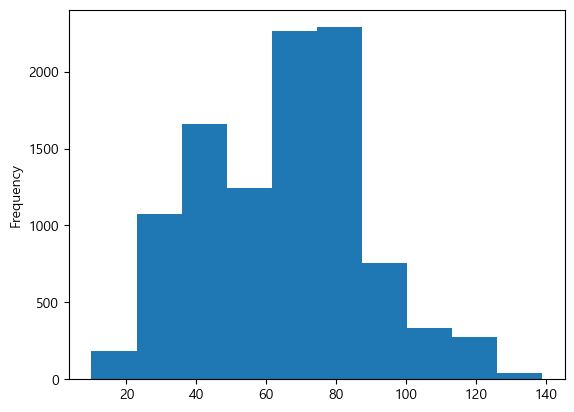

In [50]:
data['total_trans_cnt'].plot(kind='hist', bins=10)

In [58]:
low, high = get_normal_range(data['total_trans_cnt'], whis=1.5)
print(low, high)

-9.0 135.0


In [59]:
data.query('total_trans_cnt > @high').shape

(2, 19)

### total_trans_cnt
- 총 거래 횟수
- 정상범위의 최대 값으로 대체한다.
  - 정상 범위를 넘어간 값들의 개수가 많지 않으므로 같은 값으로 변경해서 하나의 값으로 만든다.

In [60]:
np.round(data['total_trans_cnt'].describe(), 2)

count    10127.00
mean        64.86
std         23.47
min         10.00
25%         45.00
50%         67.00
75%         81.00
max        139.00
Name: total_trans_cnt, dtype: float64

<Axes: ylabel='Frequency'>

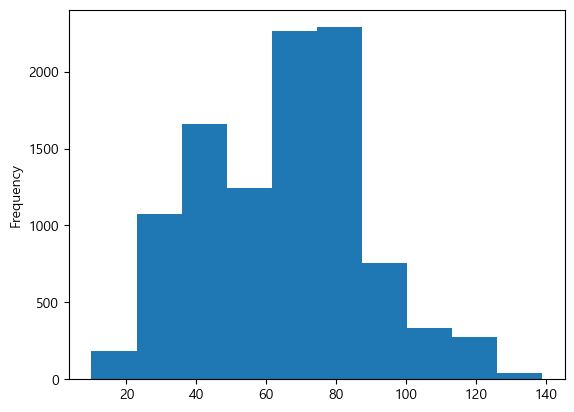

In [61]:
data['total_trans_cnt'].plot(kind='hist', bins=10)

In [62]:
low, high = get_normal_range(data['total_trans_cnt'], whis=1.5)
print(low, high)

-9.0 135.0


In [63]:
data.query('total_trans_cnt > @high').shape

(2, 19)

### 📍전처리 정리
- 결측치 처리
  - income_category: 비율에 따른 대치
  - education_level, marital_status: 최빈값으로 대체

- 이상치 처리
  - age, total_trans_ct
    - 정상범위의 최대 값으로 대체한다.  
- encoding
  - gender 
    - 라벨 인코딩(Label Encoding)
  - education_level 
    - 순서 인코딩 (Ordinal Encoding)
  - marital_status, card_category 
    - 원핫 인코딩(One-Hot encoding) 

## 📍전처리 파이프라인 생성

### 사용자 정의 전처리기 생성


In [80]:
%%writefile preprocessing.py

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# 이상치 처리
# age, total_trans_coun 전처리에 적용할 transformer 클래스
## - 정상범위 최대값, 최소값으로 대체

class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, whis=1.5):
        self.whis = whis
    
    def fit(self, X, y=None):
        q1 = np.nanquantile(X, q=0.25)
        q3 = np.nanquantile(X, q=0.75)
        IQR = q3 - q1
        self.lower_bound = q1 - IQR * self.whis
        self.upper_bound = q3 + IQR * self.whis
        return self
    
    def transform(self, X, y=None):
        X_transformed = np.where(X < self.lower_bound, self.lower_bound, X)
        X_transformed = np.where(X_transformed > self.upper_bound, self.upper_bound, X_transformed)
        return X_transformed


# 결측치 처리
class ProportionalImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.proportions = {}
    
    def fit(self, X, y=None):
        # 각 열의 비율을 계산하여 저장
        for column in X.columns:
            counts = X[column].value_counts(normalize=True, dropna=True)
            self.proportions[column] = counts
        return self
    
    def transform(self, X):
        X = X.copy()
        for column, probs in self.proportions.items():
            # 결측치 위치 찾기
            missing_mask = X[column].isna()
            if missing_mask.any():
                # 비율에 따라 랜덤하게 값 채우기
                X.loc[missing_mask, column] = np.random.choice(
                    probs.index, size=missing_mask.sum(), p=probs.values
                )
        return X 
    
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        return self.encoder.transform(X).reshape(-1, 1)  # 1D 배열을 2D로 변환하여 반환


class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categories=[]):
        print(categories)
        self.encoder = OrdinalEncoder(categories=categories)

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        return self.encoder.transform(X)  
    
    

Overwriting preprocessing.py


### 파이프라인구성

In [81]:

from preprocessing import  OutlierTransformer, ProportionalImputer, LabelEncoderTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, OrdinalEncoder



# Pipeline을 이용한 전처리
nullvalue_transformer = ColumnTransformer(
    [
        ('income_imputer', ProportionalImputer(), [5]), # income_category
        ('education_imputer', SimpleImputer(strategy='most_frequent'), [3, 4]), # education_level, marital_status
        # ('marital_imputer', SimpleImputer(strategy='most_frequent'), [4]) # marital_status
    ], remainder='passthrough'
)

outlier_transformer = ColumnTransformer(
    [
        ('age_outlier', OutlierTransformer(), [3]), # age
        ('total_trans_outlier', OutlierTransformer(), [16]) # total_trans_cnt
    ], remainder='passthrough'
)
education_categories = [["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]]
income_categories = [['Less than $40K', '$120K +', '$40K - $60K', '$60K - $80K', '$80K - $120K']]

encoder = ColumnTransformer(
    [
        ('gender_encoder', LabelEncoderTransformer(), [5]), # gender
        ('education_encoder', OrdinalEncoder(categories=education_categories), [3]), # education_level
        ('income_encoder', OrdinalEncoder(categories=income_categories), [2]), # income_category
        ('marital_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [4]), # marital_status
        ('card_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [7]) # card_category
    ], remainder='passthrough'
)

preprocessor_pipeline = Pipeline([
    ("imputer", nullvalue_transformer),
    ("outlier", outlier_transformer),
    ("encoding", encoder),
], verbose=True)

## 데이터셋 준비

In [77]:
from dataloader import load_dataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

# X, y 분리
X, y = load_dataset()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

print(X_train.shape, X_test.shape,y_train.shape, y_test.shape,)


(8101, 19) (2026, 19) (8101,) (2026,)


In [78]:
# 비율 확인
print(np.unique(y, return_counts=True)[1]/y.size)
print(np.unique(y_train, return_counts=True)[1]/y_train.size)
print(np.unique(y_test, return_counts=True)[1]/y_test.size)

[0.83934038 0.16065962]
[0.8392791 0.1607209]
[0.83958539 0.16041461]


In [ ]:
X_train_preprocessed = preprocessor_pipeline.transform(X_train)
X_test_preprocessed = preprocessor_pipeline.transform(X_test)

### 전처리 파이프라인 저장

In [14]:
import joblib
import os

os.makedirs('models', exist_ok=True)
joblib.dump(
    preprocessor_pipeline,     # 저장할 모델/전처리기
    "models/preprocessor.pkl"  # 저장경로. pickle로 저장된다.
)

['models/preprocessor.pkl']

## 모델 선정

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score)
}

['models\\best_xgb.pkl']

### 모델 생성 + 학습 + 평가가 + 하이퍼파라미터 튜닝

In [ ]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(X_train_preprocessed, y_train)

y_train_pred_tree = tree.predict(X_train_preprocessed)
y_train_proba_tree= tree.predict_proba(X_train_preprocessed)[:, 1]

params = {
    'criterion': ['gini', 'entropy'],  # 노드 분할 기준
    'max_depth': [None, 10, 20, 30],   # 각 결정 트리의 최대 깊이를 설정
    'min_samples_split': [2, 10, 20],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 5, 10],    # 리프 노드의 최소 샘플 수
    'max_features': [None, 'sqrt', 'log2']  # 각 트리가 학습할 때마다 사용할 특성(feature)의 수
}

gs_tree = GridSearchCV(
    estimator=tree,          
    param_grid=params,  
    scoring=scoring,
    refit='accuracy',
    cv=5,             
    n_jobs=-1,         
)

gs_tree.fit(X_train_preprocessed, y_train)

best_param_tree = gs_tree.best_params_
best_model_tree = gs_tree.best_estimator_

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# 1. 학습 및 예측
rf = RandomForestClassifier()

rf.fit(X_train_preprocessed, y_train)

y_train_pred_rf = rf.predict(X_train_preprocessed)
y_train_proba_rf= rf.predict_proba(X_train_preprocessed)[:, 1]

params = {
    'n_estimators': [100, 200, 300],    # 결정 트리(Decision Tree)의 개수
    'max_depth': [5, 10, 15],           # 각 결정 트리의 최대 깊이를 설정
    'max_features': ['sqrt', 'log2']    # 각 트리가 학습할 때마다 사용할 특성(feature)의 수
}
gs_rf = GridSearchCV(
    estimator=rf,       
    param_grid=params,     
    scoring=scoring,
    refit='accuracy',
    cv=5,                      
    n_jobs=-1,             
)

gs_rf.fit(X_train_preprocessed, y_train)

# 5. Best Model: 최적의 하이파라미터로 만든 모델
best_param_rf = gs_rf.best_params_
best_model_rf = gs_rf.best_estimator_

In [32]:
# Gradient Boosting
"""
====================================================================================
주요 파라미터
=======================================================a=============================
- n_estimators: 부스팅 단계의 수 = 모델이 생성할 트리 개수
- learning_rate: 학습률
- max_depth: 각 결정 트리의 최대 깊이를 설정
- subsample: 각 트리 학습에 사용되는 샘플의 비율
"""

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(X_train_preprocessed, y_train)

# 2. 모델 평가
# Train set + Test set 평가
y_train_pred_gb = gb.predict(X_train_preprocessed)
y_train_proba_gb= gb.predict_proba(X_train_preprocessed)[:, 1]

params = {
    "n_estimators": [100, 200, 300],  #  부스팅 단계의 수 = 모델이 생성할 트리 개수
    "learning_rate": [0.1],  # 학습률
    "max_depth": [1, 2, 3, 4, 5],  # 각 결정 트리의 최대 깊이를 설정
    "subsample": [0.5, 0.7],  # 샘플링 비율
}

gs_gb = GridSearchCV(
    estimator=gb,           
    param_grid=params,   
    scoring=scoring,
    refit='accuracy',
    cv=5,                  
    n_jobs=-1,            
)

gs_gb.fit(X_train_preprocessed, y_train)

best_param_gb = gs_gb.best_params_
best_model_gb = gs_gb.best_estimator_

In [ ]:
# XGBoost

from xgboost import XGBClassifier
  
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb = XGBClassifier()

xgb.fit(X_train_preprocessed, y_train)

# 2. 모델 평가
# Train set + Test set 평가
y_train_pred_xgb = xgb.predict(X_train_preprocessed)
y_train_proba_xgb= xgb.predict_proba(X_train_preprocessed)[:, 1]

fi = xgb.feature_importances_


# 4. 최적의 매개변수 구하기 - GridSearchCV
params = {
    "max_depth":[1, 2, 3, 4, 5],            # 각 결정 트리의 최대 깊이를 설정
    'learning_rate': [0.1],                 # 학습률
    'n_estimators': [100, 200, 300],        # 부스팅 단계의 수 = 모델이 생성할 트리 개수
    'subsample': [0.5, 0.7],                # 각 트리의 훈련에 사용되는 샘플 비율
    'colsample_bytree': [0.5, 0.7, 1.0],    # 각 트리의 훈련에 사용되는 피처 비율
    'gamma': [0, 0.1],                      # 노드 분할에 대한 최소 손실 감소
    'reg_alpha': [0],                       # L1 정규화
    'reg_lambda': [0.1]                     # L2 정규화
}
gs_xgb = GridSearchCV(
    estimator=xgb,           
    param_grid=params,   
    scoring=scoring,
    refit='accuracy',
    cv=5,                  
    n_jobs=-1,            
)

gs_xgb.fit(X_train_preprocessed, y_train)

# 5. 튜닝 : Best Model 찾기
best_param_xgb = gs_xgb.best_params_
best_model_xgb = gs_xgb.best_estimator_

best_y_pred_xgb = best_model_xgb.predict(X_test_preprocessed)
best_y_proba_xgb= best_model_xgb.predict_proba(X_test_preprocessed)[:, 1]

### 모델 저장, 최종 테스트

In [ ]:
directory = 'models/'
os.makedirs(directory, exist_ok=True)

joblib.dump(best_model_tree, os.path.join(directory, 'best_tree.pkl'))
joblib.dump(best_model_rf, os.path.join(directory, 'best_rf.pkl'))
joblib.dump(best_model_gb, os.path.join(directory, 'best_gb.pkl'))
joblib.dump(best_model_xgb, os.path.join(directory, 'best_xgb.pkl'))
